# Oral Machine learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# classe des systèmes dynamiques

class Dynamical_system():
    def __init__(self, dim, v, dt, T):
        self.dim = dim
        self.v = v
        self.T = T
        self.dt = dt
        self.t = np.arange(T)*dt
        self.traj  = np.zeros((self.T,self.dim))

    def random_traj(self):
        self.traj = odeint(self.v,np.random.randn(self.dim),self.t)
        return self.traj
    
    def compute_traj(self,x0):
        self.traj = odeint(self.v,x0,self.t)
        return self.traj

    def gen_data(self, bs):
        data = np.zeros((bs,self.T,self.dim),dtype=np.double)
        for i in range(bs):
            data[i] = self.random_traj()
        return torch.tensor(data)

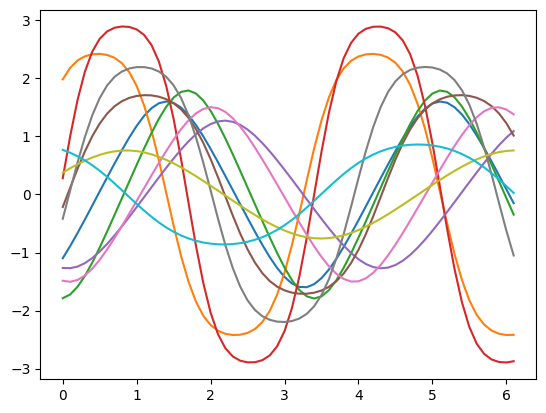

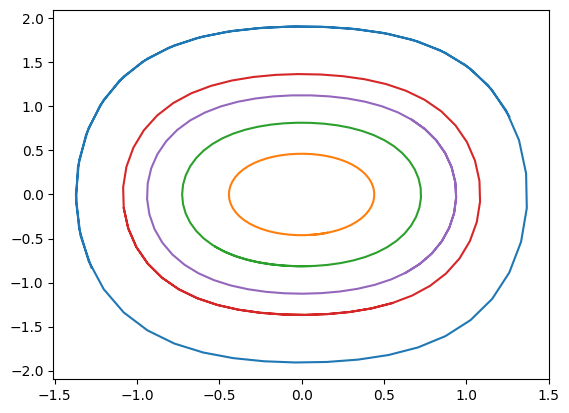

In [3]:
#test et training set

dt = .1

def v(x,t):
    return np.array([x[1], -x[0]*(1+x[0]**2)])

#F = np.vectorize(F)
dim = 2
T =int(2*np.pi/dt)

pendulum = Dynamical_system(dim,v,dt,T)

for k in range(5):
    pendulum.random_traj()
    plt.plot(pendulum.t, pendulum.traj)
plt.show()

for k in range(5):
    pendulum.random_traj()
    plt.plot(*pendulum.traj.T)

In [4]:
#  deep Neural network

class Koopman(nn.Module):

    def __init__(self, dynamical_system, encoding_dim, phi_hl_dim=80,lambda_hl_dim=170,alpha1=.001,S_p=30):
        super(Koopman, self).__init__()
        self.dt = dynamical_system.dt
        self.T = dynamical_system.T
        self.input_dim = dynamical_system.dim
        self.phi_hl_dim = phi_hl_dim
        self.lambda_hl_dim = lambda_hl_dim
        self.encoding_dim = encoding_dim
        self.alpha1 = alpha1
        self.S_p = S_p
        self.phi =nn.Sequential(
            nn.Linear(self.input_dim, self.phi_hl_dim),
            nn.ReLU(),
            nn.Linear(self.phi_hl_dim, self.phi_hl_dim),
            nn.ReLU(),
            nn.Linear(self.phi_hl_dim, self.encoding_dim),
            )
        self.phi_inv = self.decoder = nn.Sequential(
            nn.Linear(self.encoding_dim, self.phi_hl_dim),
            nn.ReLU(),
            nn.Linear(self.phi_hl_dim, self.phi_hl_dim),
            nn.ReLU(),
            nn.Linear(self.phi_hl_dim, self.input_dim)
            )
        self.Lambda = nn.Sequential(
            nn.Linear(self.encoding_dim, self.lambda_hl_dim),
            nn.ReLU(),
            nn.Linear(self.lambda_hl_dim, 1),
            )
        
    # def forward(self, traj):
    #     output = torch.zeros((self.T,2*self.encoding_dim+self.input_dim),dtype=torch.double)
    #     output[0,:self.encoding_dim] = self.phi(traj[0])
    #     omega = self.Lambda(output[0,:self.encoding_dim])
    #     K = torch.tensor([[torch.cos(omega*self.dt),torch.sin(omega*self.dt)],
    #                       [-torch.sin(omega*self.dt), torch.cos(omega*self.dt)]],dtype=torch.double)
    #     for i in range(1,self.T):
    #         output[i,:self.encoding_dim] = output[i-1,:self.encoding_dim]@K
    #     output[:,self.encoding_dim:self.encoding_dim+self.input_dim] = self.phi(output[:,:self.encoding_dim])
    #     output[:,self.encoding_dim+self.input_dim:] = self.phi(traj)
    #     return output
    
    def forward(self, traj):
        output = torch.zeros((self.T,2*self.encoding_dim+self.input_dim),dtype=torch.double)
        output[0,:self.encoding_dim] = self.phi(traj[0])
        omega = self.Lambda(output[0,:self.encoding_dim])
        K = torch.tensor([[torch.cos(omega*self.dt),torch.sin(omega*self.dt)],
                          [-torch.sin(omega*self.dt), torch.cos(omega*self.dt)]],dtype=torch.double)
        for i in range(1,self.T):
            output[i,:self.encoding_dim] = output[i-1,:self.encoding_dim].clone()@K
        output[:,self.encoding_dim:self.encoding_dim+self.input_dim] = self.phi_inv(output[:,:self.encoding_dim].clone())
        output[:,self.encoding_dim+self.input_dim:] = self.phi(traj)
        return output
    
    def test_encoder(self,x):
        return self.phi_inv(self.phi(x))

loss

In [7]:
def loss_fn(pred,true,input_dim,encoding_dim,alpha1=.001,S_p=30,alpha2=1e-9): #alpha3=1e-14
    l_recon = torch.mean((pred[0,    encoding_dim:encoding_dim+input_dim]-true[0    ])**2)
    l_pred  = torch.mean((pred[1:S_p,encoding_dim:encoding_dim+input_dim]-true[1:S_p])**2)
    l_lin   = torch.mean((pred[:,:encoding_dim]-pred[:,encoding_dim+input_dim:])**2)
    l_infty = torch.max(pred[0,encoding_dim:encoding_dim+input_dim]-true[0])\
             +torch.max(pred[1,encoding_dim:encoding_dim+input_dim]-true[1])
    return alpha1*(l_recon+l_pred)+l_lin+alpha2*l_infty

In [15]:
def train(data,bs, model, loss_fn, optimizer):
    model.train()
    losses = []
    pn = 10
    try:
        for k in range(bs):
            output = model.forward(data[k])
            loss = loss_fn(output, data[k],model.input_dim,model.encoding_dim)
            if k%(bs//pn)==0:
                print(f"{100*k/bs : 1.1f}% done, loss={loss: 1.2e}")
            losses.append(loss.detach().numpy())
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    except KeyboardInterrupt:
        return losses
    print("last loss = ", loss.detach().numpy())
    return losses
    #l = test_encoder(model,loss_fn, N=20)
    #print("Encoder loss = ", l)
    #q = test_dynamic(model,loss_fn, data,N=20)
    #print("Dynamic loss = ", q)

In [10]:
def test(traj,model):
    pred = model(traj)
    phi_traj[0,:] = model.phi(x_0)
    for k in range(T):
        phi_traj[k,:] = model.K(phi_traj[k-1,:])
    return model.phi_inv(phi_traj)

In [11]:
def test_encoder(model,loss_fn, N):
    test_set = torch.randn([model.input_dim,N], dtype = torch.double)
    pred = model.phi_inv(model.phi(test_set))
    l = loss_fn(pred,test_set)
    return l

In [12]:
def test_dynamic(model,loss_fn,data, N):
    test_set = data[:N,:]
    pred = model.phi_inv(model.K(model.phi(test_set[:,:model.input_dim])))
    l = loss_fn(pred,test_set)

## Test

In [9]:
dim = 2
def v(x,t):
    return np.array([x[1], -x[0]*(1+x[0]**2)])
dt = .1
T =int(2*np.pi/dt)

oscillator = Dynamical_system(dim,v,dt,T)
bs = 10000

traning_set = oscillator.gen_data(bs)

In [10]:
encoding_dim = 2
model = Koopman(oscillator, encoding_dim)
model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
epochs = 30
losses = []
for t in range(epochs):
    print("epoch = ",t)
    losses = losses+train(traning_set, bs, model, loss_fn, optimizer)
print("Done!")

epoch =  0
 0.0% done, loss= 6.28e-03
 10.0% done, loss= 1.82e-04
 20.0% done, loss= 9.64e-04
 30.0% done, loss= 4.68e-03
 40.0% done, loss= 1.42e-03
 50.0% done, loss= 2.18e-03
 60.0% done, loss= 9.97e-04
 70.0% done, loss= 3.28e-04
 80.0% done, loss= 9.65e-04
 90.0% done, loss= 1.67e-03
last loss =  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch =  1
 0.0% done, loss= 6.22e-03
 10.0% done, loss= 1.80e-04
 20.0% done, loss= 9.64e-04
 30.0% done, loss= 4.68e-03
 40.0% done, loss= 1.42e-03
 50.0% done, loss= 2.18e-03
 60.0% done, loss= 9.97e-04
 70.0% done, loss= 3.28e-04
 80.0% done, loss= 9.65e-04
 90.0% done, loss= 1.67e-03
last loss =  tensor(0.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch =  2
 0.0% done, loss= 6.22e-03
 10.0% done, loss= 1.80e-04
 20.0% done, loss= 9.64e-04
 30.0% done, loss= 4.68e-03
 40.0% done, loss= 1.42e-03
 50.0% done, loss= 2.18e-03
 60.0% done, loss= 9.97e-04
 70.0% done, loss= 3.28e-04
 80.0% done, loss= 9.65e-04
 90.0% done,

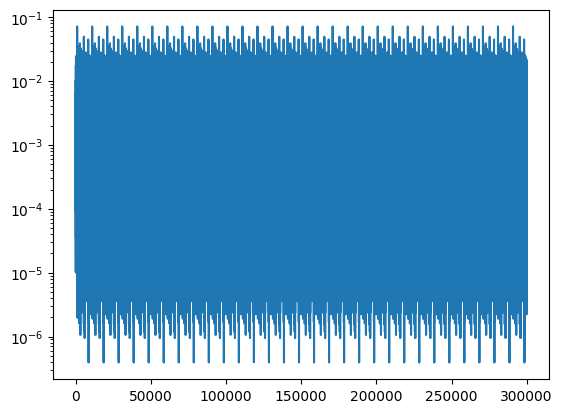

In [17]:
plt.semilogy(losses)
plt.show()

In [18]:
x_0 = torch.randn(2,dtype=torch.double)
traj_true = pendulum.compute_traj(x_0)
traj_pred = model(torch.tensor(traj_true,dtype=torch.double)).detach().numpy()

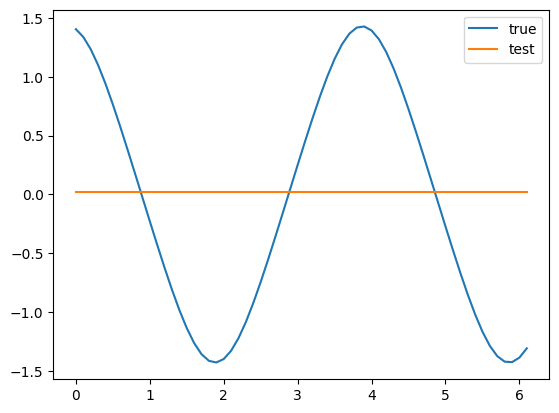

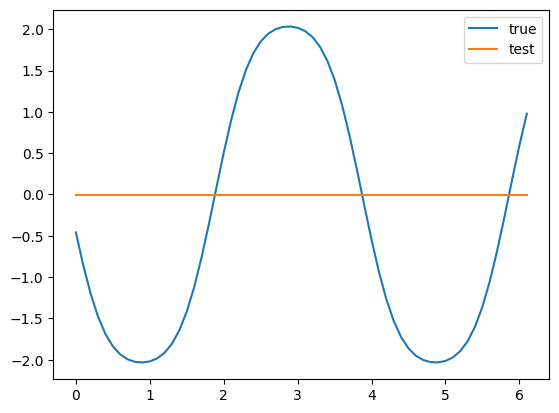

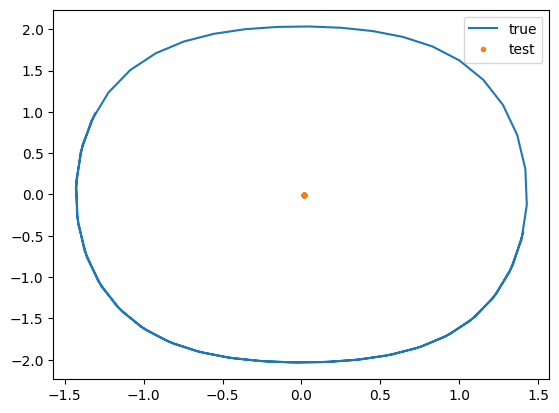

In [19]:
for i in range(dim):
    plt.plot(pendulum.t, traj_true[:,i] ,label = 'true')
    plt.plot(pendulum.t, traj_pred[:,encoding_dim+i], label='test')
    plt.legend()
    plt.show()

plt.plot(*traj_true.T,label = 'true')
plt.plot(*traj_pred[:,encoding_dim:encoding_dim+dim].T, ".", label='test')
plt.legend()
plt.show()

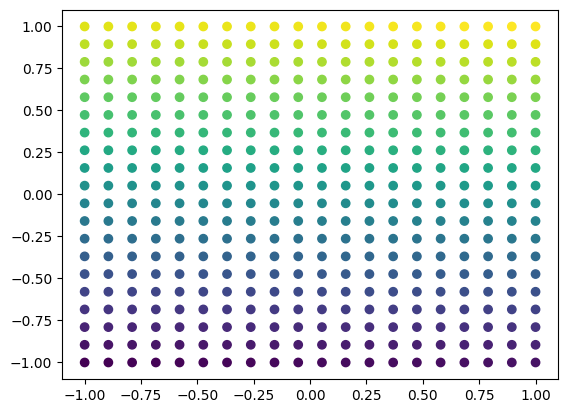

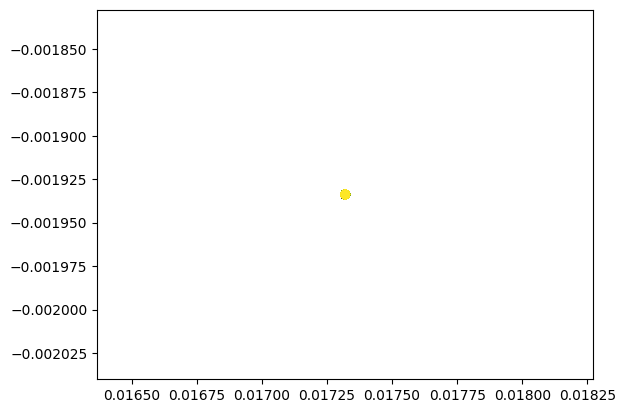

In [20]:
N = 20
colors = np.linspace(0,100,N**2)
x0 = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
for i in range(2):
    x0[i].flatten()
x0 = np.array(x0)
x1 = model.test_encoder(torch.tensor(x0.T))
x1 = x1.detach().numpy().T
plt.scatter(*x0,c=colors, cmap='viridis')
plt.show()
plt.scatter(*x1,c=colors, cmap='viridis')
plt.show()